In [245]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

np.random.seed(42)

In [279]:
class Node():
    
    node_id = 0
    
    def __init__(self, left=None, right=None, threshold=None, feature_num=None, label=None):
        
        self.left = left
        self.right = right
        self.threshold = threshold
        self.feature_num = feature_num
        self.label = label
        
        self.node_id = Node.node_id
        Node.node_id += 1
        

In [269]:
def calculate_entropy(y):
    
    if (y.shape[0] == 0):
        return 0.0
    
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = y.shape[0]
    
    p = class_counts/total_samples
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_information_gain(y, y_left, y_right):
    
    root_entropy = calculate_entropy(y)
    left_entropy = calculate_entropy(y_left)
    right_entropy = calculate_entropy(y_right)

    info_gain = root_entropy - (((y_left.shape[0] / y.shape[0]) * left_entropy) + ((y_right.shape[0] / y.shape[0]) * right_entropy))
    return info_gain

def calculate_gain_ratio(X, y, y_left, y_right):

    info_gain = calculate_information_gain(y, y_left, y_right)
    feature_entropy = - (y_left.shape[0]/y.shape[0])*np.log2(y_left.shape[0]/y.shape[0]) - (y_right.shape[0]/y.shape[0])*np.log2(y_right.shape[0]/y.shape[0])   # calculate_entropy(X)
    gain_ratio = info_gain / feature_entropy
    return gain_ratio

def find_best_split(X,y):
    
    best_split_found = False
    max_gain_ratio = -1
    feature_num = 1
    c = 0
    best_X_left = None
    best_y_left = None
    best_X_right = None
    best_y_right = None

    for i in range(0,X.shape[1]):
        for j in list(np.unique(X[:,i])):

            left_samples = np.where(X[:,i] >= j)[0]
            X_left = X[left_samples]
            y_left = y[left_samples]
            
            right_samples = np.where(X[:,i] < j)[0]
            X_right = X[right_samples]
            y_right = y[right_samples]
            
            if(y_left.shape[0]==0 or y_right.shape[0]==0):
                #Q3
                info_gain = calculate_information_gain(y, y_left, y_right)
#                 print(f"Feature: x{i+1}, Threshold {j}, Information Gain: {info_gain}")
                continue
            
            
            gain_ratio = calculate_gain_ratio(X[:,i], y, y_left, y_right)
            
            if(gain_ratio > max_gain_ratio):
                max_gain_ratio = gain_ratio
                best_split_found = True
                c = j
                feature_num = i + 1
                best_X_left = X[left_samples]
                best_y_left = y[left_samples]
                best_X_right = X[right_samples]
                best_y_right = y[right_samples]
            
            #Q3
#             print(f"Feature: x{i+1}, Threshold {j}, Gain Ratio: {gain_ratio}")
    
    print(f"Split: (Feature: x{feature_num}, Threshold {c}, Gain Ratio: {max_gain_ratio})")      
    return best_X_left, best_y_left, best_X_right, best_y_right, c, feature_num, max_gain_ratio, best_split_found

def create_tree(X,y):
    
    # stopping criteria
    if(y.shape[0] == 0):            #if the node is empty
        leaf = Node(label=1)     
        return leaf
    
    if(len(list(np.unique(y)))==1):
        leaf = Node(label=y[0])
        return leaf
    
    X_left, y_left, X_right, y_right, c, feature_num, max_gain_ratio, best_split_found = find_best_split(X,y)
    
    #Q3
#     return
    if(max_gain_ratio==0):
        leaf = Node(label=np.bincount(y).argmax())
        return leaf
    
    left_tree = create_tree(X_left, y_left)
    right_tree = create_tree(X_right, y_right)
    

    tree = Node(left=left_tree, right=right_tree, threshold=c, feature_num=feature_num)

    return tree

def predict(X, root):
    
    y_pred = []
    
    for i in range(0, X.shape[0]):
        
        node = root
        
        while node.label == None:
            
            if X[i,node.feature_num] >= node.threshold:
                node = node.left
            else:
                node = node.right

        y_pred.append(node.label)
    
    return y_pred

In [270]:
# Load data
def load_data(filename):
    
    data = os.path.join(filename)
    data = np.loadtxt(data)

    X = data[:,:-1]
    y = data[:,-1]
    
    return X,y

## Question 2.3

In [265]:
X, y = load_data("Druns.txt")

In [266]:
root3 = create_tree(X,y)

Feature: x1, Threshold 0.0, Information Gain: 0.0
Feature: x1, Threshold 0.1, Gain Ratio: 0.10051807676021828
Feature: x2, Threshold -2.0, Information Gain: 0.0
Feature: x2, Threshold -1.0, Gain Ratio: 0.10051807676021828
Feature: x2, Threshold 0.0, Gain Ratio: 0.055953759631263526
Feature: x2, Threshold 1.0, Gain Ratio: 0.00578004220515232
Feature: x2, Threshold 2.0, Gain Ratio: 0.0011443495172767494
Feature: x2, Threshold 3.0, Gain Ratio: 0.016411136842102134
Feature: x2, Threshold 4.0, Gain Ratio: 0.049749064181778546
Feature: x2, Threshold 5.0, Gain Ratio: 0.11124029586339801
Feature: x2, Threshold 6.0, Gain Ratio: 0.23609960614360798
Feature: x2, Threshold 7.0, Gain Ratio: 0.055953759631263526
Feature: x2, Threshold 8.0, Gain Ratio: 0.4301569161309807
Split: (Feature: x2, Threshold 8.0, Gain Ratio: 0.4301569161309807)


## Question 2.4

In [271]:
def to_logic_rules(root, indent=""):
    if root is None:
        return
    elif root.left is None and root.right is None:
        print(f"{indent}|--- class: {'%d' %(root.label)}")
    else:
        condition = f"{indent}|--- if x{root.feature_num} >= {root.threshold}"
        print(condition)
        to_logic_rules(root.left, indent + "    ")
        condition = f"{indent}|--- elif x{root.feature_num} < {root.threshold}"
        print(condition)
        to_logic_rules(root.right, indent + "    ")

In [272]:
X, y = load_data("D3leaves.txt")

In [273]:
root4 = create_tree(X,y)

Split: (Feature: x1, Threshold 10.0, Gain Ratio: 0.33155970728682876)
Split: (Feature: x2, Threshold 3.0, Gain Ratio: 1.0)


In [274]:
to_logic_rules(root4)

|--- if x1 >= 10.0
    |--- class: 1
|--- elif x1 < 10.0
    |--- if x2 >= 3.0
        |--- class: 1
    |--- elif x2 < 3.0
        |--- class: 0


## Question 2.5

In [276]:
X, y = load_data("D1.txt")

In [277]:
root5_1 = create_tree(X,y)

Split: (Feature: x2, Threshold 0.201829, Gain Ratio: 1.0)


In [278]:
to_logic_rules(root5_1)

|--- if x2 >= 0.201829
    |--- class: 1
|--- elif x2 < 0.201829
    |--- class: 0


In [280]:
X, y = load_data("D2.txt")

In [281]:
root5_2 = create_tree(X,y)

Split: (Feature: x1, Threshold 0.533076, Gain Ratio: 0.2238061143668733)
Split: (Feature: x2, Threshold 0.228007, Gain Ratio: 0.40277675382774364)
Split: (Feature: x2, Threshold 0.424906, Gain Ratio: 0.1751133281825154)
Split: (Feature: x1, Threshold 0.708127, Gain Ratio: 0.5206601917193016)
Split: (Feature: x2, Threshold 0.32625, Gain Ratio: 0.34644489742573253)
Split: (Feature: x1, Threshold 0.595471, Gain Ratio: 0.5023576805798505)
Split: (Feature: x1, Threshold 0.646007, Gain Ratio: 0.3191750665186214)
Split: (Feature: x2, Threshold 0.403494, Gain Ratio: 1.0)
Split: (Feature: x1, Threshold 0.887224, Gain Ratio: 0.5381401523569376)
Split: (Feature: x2, Threshold 0.037708, Gain Ratio: 0.6832381679130689)
Split: (Feature: x2, Threshold 0.082895, Gain Ratio: 0.1916139235269724)
Split: (Feature: x1, Threshold 0.960783, Gain Ratio: 1.0)
Split: (Feature: x1, Threshold 0.850316, Gain Ratio: 0.2519373889044624)
Split: (Feature: x2, Threshold 0.169053, Gain Ratio: 1.0)
Split: (Feature: x2, T

In [282]:
to_logic_rules(root5_2)

|--- if x1 >= 0.533076
    |--- if x2 >= 0.228007
        |--- if x2 >= 0.424906
            |--- class: 1
        |--- elif x2 < 0.424906
            |--- if x1 >= 0.708127
                |--- class: 1
            |--- elif x1 < 0.708127
                |--- if x2 >= 0.32625
                    |--- if x1 >= 0.595471
                        |--- if x1 >= 0.646007
                            |--- class: 1
                        |--- elif x1 < 0.646007
                            |--- if x2 >= 0.403494
                                |--- class: 1
                            |--- elif x2 < 0.403494
                                |--- class: 0
                    |--- elif x1 < 0.595471
                        |--- class: 0
                |--- elif x2 < 0.32625
                    |--- class: 0
    |--- elif x2 < 0.228007
        |--- if x1 >= 0.887224
            |--- if x2 >= 0.037708
                |--- if x2 >= 0.082895
                    |--- class: 1
                |--- elif

## Qestion 2.6

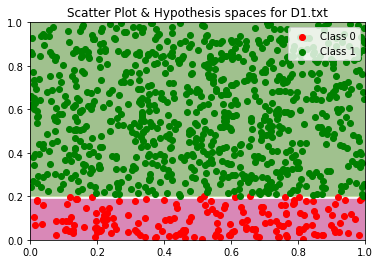

In [143]:
X, y = load_data("D1.txt")
root6_1 = create_tree(X,y)

xx, yy = np.meshgrid(np.linspace(0, 1, 50),  np.linspace(0, 1, 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, root6_1)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X[np.where(y<1)[0],0], X[np.where(y<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X[np.where(y>0)[0],0], X[np.where(y>0)[0],1], c='g', label='Class 1', marker='o')


plt.title('Scatter Plot & Hypothesis spaces for D1.txt')
plt.legend(loc='upper right')

plt.show()

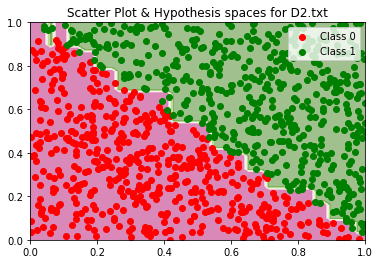

In [145]:
X, y = load_data("D2.txt")
root6_2 = create_tree(X,y)


xx, yy = np.meshgrid(np.linspace(0, 1, 50),  np.linspace(0, 1, 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, root6_2)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X[np.where(y<1)[0],0], X[np.where(y<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X[np.where(y>0)[0],0], X[np.where(y>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Scatter Plot & Hypothesis spaces for D2.txt')
plt.legend(loc='upper right')

plt.ylim([-0.2, 0.2])

plt.show()

## Question 2.7

In [147]:
def train_test_split(X, y, train_size):
    np.random.seed(32)
    
    num_rows = X.shape[0]
    total_indices = np.random.permutation(num_rows)

    train_indices = total_indices[:train_size]
    test_indices = total_indices[train_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test

In [148]:
def subset(X_train, y_train, subset_size):
    
    X_train_sub = X_train[:subset_size,:]
    y_train_sub = y_train[:subset_size]
    
    return X_train_sub, y_train_sub

In [155]:
X, y = load_data("Dbig.txt")

In [156]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 8192)

Training data shape: (8192, 2)
Test data shape: (1808, 2)


In [157]:
X_train_32, y_train_32 = subset(X_train, y_train, 32)
tree_32 = create_tree(X_train_32, y_train_32)
y_pred = predict(X_test, tree_32)
error_32 = 1 - (np.sum(np.array(y_pred) == y_test) / y_test.shape[0])

print(f"n=32, number of nodes={tree_32.node_id}, error={error_32}")

n=32, number of nodes=12, error=0.08738938053097345


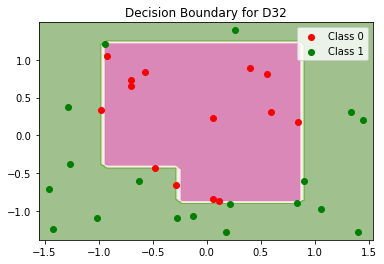

In [158]:
xx, yy = np.meshgrid(np.linspace(np.min(X_train_32[:,0])-0.1, np.max(X_train_32[:,0])+0.1, 50),  np.linspace(np.min(X_train_32[:,1])-0.1, np.max(X_train_32[:,1]+0.1), 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, tree_32)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X_train_32[np.where(y_train_32<1)[0],0], X_train_32[np.where(y_train_32<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X_train_32[np.where(y_train_32>0)[0],0], X_train_32[np.where(y_train_32>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Decision Boundary for D32')
plt.legend(loc='upper right')

plt.show()

In [160]:
X_train_128, y_train_128 = subset(X_train, y_train, 128)
tree_128 = create_tree(X_train_128, y_train_128)
y_pred = predict(X_test, tree_128)
error_128 = 1 - (np.sum(np.array(y_pred) == y_test) / y_test.shape[0])

print(f"n=128, number of nodes={tree_128.node_id}, error={error_128}")

n=128, number of nodes=14, error=0.07079646017699115


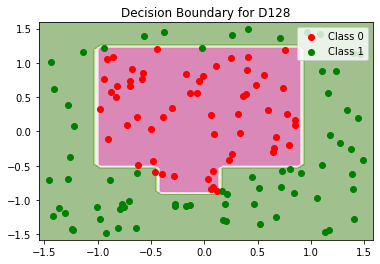

In [161]:
xx, yy = np.meshgrid(np.linspace(np.min(X_train_128[:,0])-0.1, np.max(X_train_128[:,0])+0.1, 50),  np.linspace(np.min(X_train_128[:,1])-0.1, np.max(X_train_128[:,1]+0.1), 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, tree_128)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X_train_128[np.where(y_train_128<1)[0],0], X_train_128[np.where(y_train_128<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X_train_128[np.where(y_train_128>0)[0],0], X_train_128[np.where(y_train_128>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Decision Boundary for D128')
plt.legend(loc='upper right')

plt.show()

In [163]:
X_train_512, y_train_512 = subset(X_train, y_train, 512)
tree_512 = create_tree(X_train_512, y_train_512)
y_pred = predict(X_test, tree_512)
error_512 = 1 - (np.sum(np.array(y_pred) == y_test) / y_test.shape[0])

print(f"n=512, number of nodes={tree_512.node_id}, error={error_512}")

n=512, number of nodes=58, error=0.06028761061946908


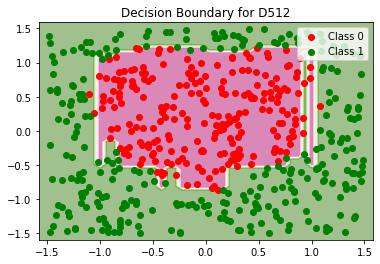

In [164]:
xx, yy = np.meshgrid(np.linspace(np.min(X_train_512[:,0])-0.1, np.max(X_train_512[:,0])+0.1, 50),  np.linspace(np.min(X_train_512[:,1])-0.1, np.max(X_train_512[:,1]+0.1), 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, tree_512)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X_train_512[np.where(y_train_512<1)[0],0], X_train_512[np.where(y_train_512<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X_train_512[np.where(y_train_512>0)[0],0], X_train_512[np.where(y_train_512>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Decision Boundary for D512')
plt.legend(loc='upper right')

plt.show()

In [167]:
X_train_2048, y_train_2048 = subset(X_train, y_train, 2048)
tree_2048 = create_tree(X_train_2048, y_train_2048)
y_pred = predict(X_test, tree_2048)
error_2048 = 1 - (np.sum(np.array(y_pred) == y_test) / y_test.shape[0])

print(f"n=2048, number of nodes={tree_2048.node_id}, error={error_2048}")

n=2048, number of nodes=140, error=0.03263274336283184


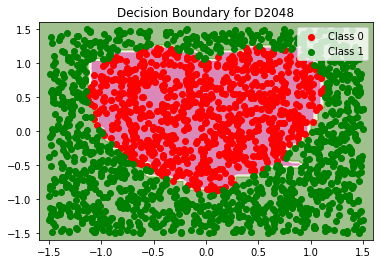

In [168]:
xx, yy = np.meshgrid(np.linspace(np.min(X_train_2048[:,0])-0.1, np.max(X_train_2048[:,0])+0.1, 50),  np.linspace(np.min(X_train_2048[:,1])-0.1, np.max(X_train_2048[:,1]+0.1), 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, tree_2048)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X_train_2048[np.where(y_train_2048<1)[0],0], X_train_2048[np.where(y_train_2048<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X_train_2048[np.where(y_train_2048>0)[0],0], X_train_2048[np.where(y_train_2048>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Decision Boundary for D2048')
plt.legend(loc='upper right')

plt.show()

In [170]:
tree_8192 = create_tree(X_train, y_train)
y_pred = predict(X_test, tree_8192)
error_8192 = 1 - (np.sum(np.array(y_pred) == y_test) / y_test.shape[0])

print(f"n=8192, number of nodes={tree_8192.node_id}, error={error_8192}")

n=8192, number of nodes=264, error=0.01603982300884954


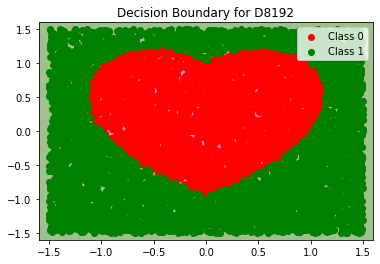

In [171]:
xx, yy = np.meshgrid(np.linspace(np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1, 50),  np.linspace(np.min(X_train[:,1])-0.1, np.max(X_train[:,1]+0.1), 50))
X_mesh = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), 1)
Y_mesh = predict(X_mesh, tree_8192)

plt.contourf(xx, yy, np.reshape(np.array(Y_mesh), (50, 50)), alpha=0.5, cmap='PiYG')

plt.scatter(X_train[np.where(y_train<1)[0],0], X_train[np.where(y_train<1)[0],1], c='r', label='Class 0', marker='o')
plt.scatter(X_train[np.where(y_train>0)[0],0], X_train[np.where(y_train>0)[0],1], c='g', label='Class 1', marker='o')

plt.title('Decision Boundary for D8192')
plt.legend(loc='upper right')

plt.show()

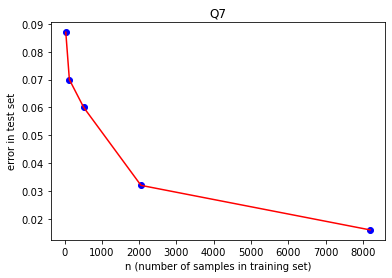

In [172]:
n = [32, 128, 512, 2048, 8192]
error = [0.087, 0.070, 0.060, 0.032, 0.016]

# Create a scatter plot
plt.scatter(n, error, color='blue', marker='o')
# Create lines connecting the points
plt.plot(n, error, linestyle='-', color='red')

plt.xlabel('n (number of samples in training set)')
plt.ylabel('error in test set')
plt.title('Q7')

# Show the plot
plt.show()

## Question 3

In [173]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [174]:
clf_32 = DecisionTreeClassifier(criterion="entropy")
clf_32 = clf_32.fit(X_train_32,y_train_32)
y_pred = clf_32.predict(X_test)

error_32 = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"n=32, number of nodes={clf_32.tree_.node_count}, error={error_32}")

n=32, number of nodes=13, error=0.11172566371681414


In [175]:
clf_128 = DecisionTreeClassifier(criterion="entropy")
clf_128 = clf_128.fit(X_train_128,y_train_128)
y_pred = clf_128.predict(X_test)

error_128 = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"n=128, number of nodes={clf_128.tree_.node_count}, error={error_128}")

n=128, number of nodes=15, error=0.07190265486725667


In [176]:
clf_512 = DecisionTreeClassifier(criterion="entropy")
clf_512 = clf_512.fit(X_train_512,y_train_512)
y_pred = clf_512.predict(X_test)

error_512 = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"n=512, number of nodes={clf_512.tree_.node_count}, error={error_512}")

n=512, number of nodes=63, error=0.05752212389380529


In [177]:
clf_2048 = DecisionTreeClassifier(criterion="entropy")
clf_2048 = clf_2048.fit(X_train_2048,y_train_2048)
y_pred = clf_2048.predict(X_test)

error_2048 = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"n=2048, number of nodes={clf_2048.tree_.node_count}, error={error_2048}")

n=2048, number of nodes=125, error=0.020464601769911495


In [178]:
clf_8192 = DecisionTreeClassifier(criterion="entropy")
clf_8192 = clf_8192.fit(X_train,y_train)
y_pred = clf_8192.predict(X_test)

error_8192 = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"n=8192, number of nodes={clf_8192.tree_.node_count}, error={error_8192}")

n=8192, number of nodes=229, error=0.01382743362831862


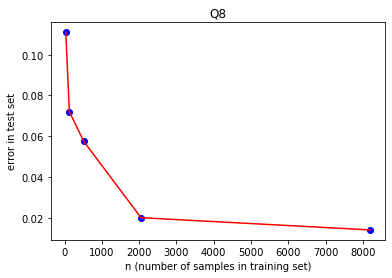

In [179]:
n = [32, 128, 512, 2048, 8192]
error = [0.111, 0.072, 0.0575, 0.020, 0.014]

# Create a scatter plot
plt.scatter(n, error, color='blue', marker='o')
# Create lines connecting the points
plt.plot(n, error, linestyle='-', color='red')

plt.xlabel('n (number of samples in training set)')
plt.ylabel('error in test set')
plt.title('Q8')

# Show the plot
plt.show()

## Question4

### Without noise

Train error: 353.7814152394696
Test error: 354.4354753206732


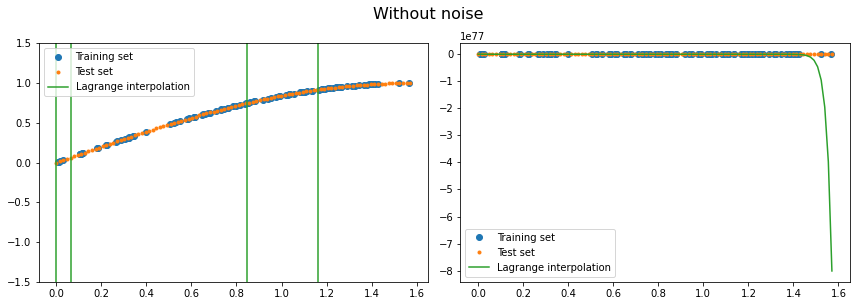

In [239]:
X_train = np.random.uniform(a, b, n)     
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

# plt.plot(X_train, y_train, 'o', label='Training set')
# plt.plot(X_test, y_test, '.', label='Test set')
# plt.plot(X_test, y_test_pred, label='Lagrange interpolation')
# plt.ylim(-1.5, 1.5)
# plt.legend()
# plt.title('Without noise')
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()
fig.suptitle('Without noise', fontsize=16, y=1.05)
# Show the plots
plt.show()

### With epsilon=0.1

Train error: 341.0303338681083
Test error: 335.53989675486014


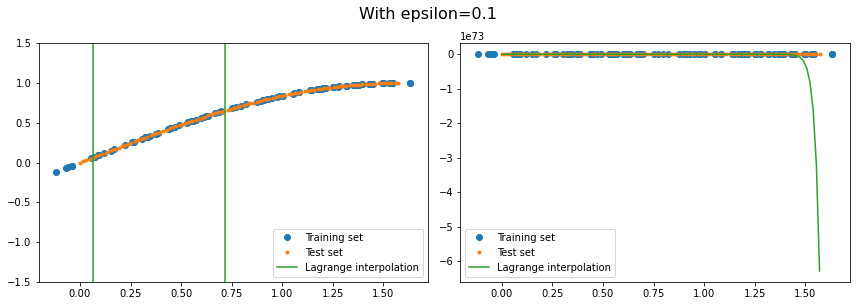

In [240]:
a = 0
b = np.pi / 2 
n = 100
epsilon = 0.1

X_train = np.random.uniform(a, b, n) + np.random.normal(0, epsilon, n)    
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

# plt.plot(X_train, y_train, 'o', label='Training set')
# plt.plot(X_test, y_test, '.', label='Test set')
# plt.plot(X_test, y_test_pred, label='Lagrange interpolation')
# plt.ylim(-1.5, 1.5)
# plt.legend()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()
fig.suptitle('With epsilon=0.1', fontsize=16, y=1.05)
# Show the plots
plt.show()

### With epsilon=0.5

Train error: 377.7186773911298
Test error: 312.8881738254513


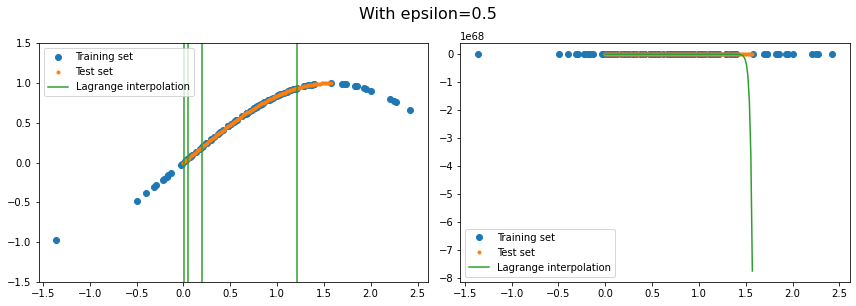

In [241]:
a = 0
b = np.pi / 2 
n = 100
epsilon = 0.5

X_train = np.random.uniform(a, b, n) + np.random.normal(0, epsilon, n)    
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

# plt.plot(X_train, y_train, 'o', label='Training set')
# plt.plot(X_test, y_test, '.', label='Test set')
# plt.plot(X_test, y_test_pred, label='Lagrange interpolation')
# plt.ylim(-1.5, 1.5)
# plt.legend()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()
fig.suptitle('With epsilon=0.5', fontsize=16, y=1.05)
# Show the plots
plt.show()

### With epsilon=1

Train error: 272.1250958965215
Test error: 187.87877618163884


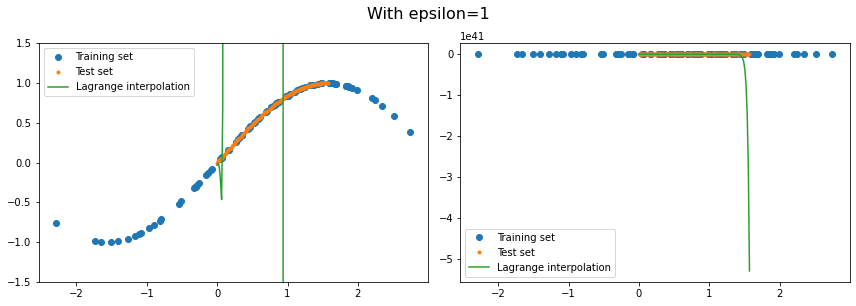

In [242]:
a = 0
b = np.pi / 2 
n = 100
epsilon = 1

X_train = np.random.uniform(a, b, n) + np.random.normal(0, epsilon, n)    
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

# plt.plot(X_train, y_train, 'o', label='Training set')
# plt.plot(X_test, y_test, '.', label='Test set')
# plt.plot(X_test, y_test_pred, label='Lagrange interpolation')
# plt.ylim(-1.5, 1.5)
# plt.legend()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()
fig.suptitle('With epsilon=1', fontsize=16, y=1.05)
# Show the plots
plt.show()

### With epsilon=3

Train error: 234.79787667375402
Test error: 30.306752635929975


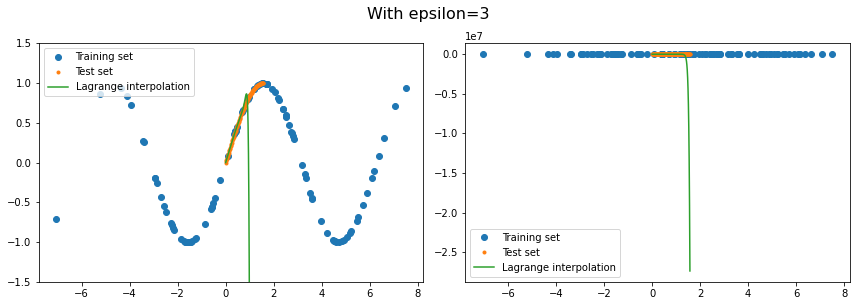

In [243]:
a = 0
b = np.pi / 2 
n = 100
epsilon = 3

X_train = np.random.uniform(a, b, n) + np.random.normal(0, epsilon, n)    
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

# plt.plot(X_train, y_train, 'o', label='Training set')
# plt.plot(X_test, y_test, '.', label='Test set')
# plt.plot(X_test, y_test_pred, label='Lagrange interpolation')
# plt.ylim(-1.5, 1.5)
# plt.legend()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()
fig.suptitle('With epsilon=3', fontsize=16, y=1.05)
# Show the plots
plt.show()

### With epsilon=5

Train error: 269.7684076131159
Test error: 3.162278728868414


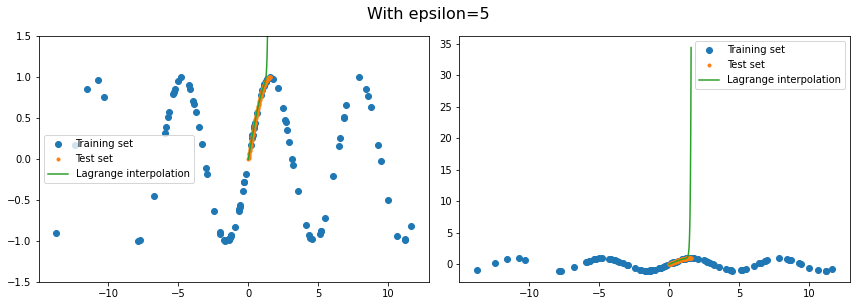

In [244]:
a = 0
b = np.pi / 2 
n = 100
epsilon = 5

X_train = np.random.uniform(a, b, n) + np.random.normal(0, epsilon, n)    
y_train = np.sin(X_train)

X_test = np.linspace(a, b, 100)
y_test = np.sin(X_test)

poly = lagrange(X_train, y_train)
y_train_pred = poly(X_train) 
y_test_pred = poly(X_test) 

#log MSE
train_error = np.log(np.mean((y_train - y_train_pred)**2))
test_error = np.log(np.mean((y_test - y_test_pred)**2))

print("Train error:", train_error)
print("Test error:", test_error)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the data in the first subplot (axs[0])
axs[0].plot(X_train, y_train, 'o', label='Training set')
axs[0].plot(X_test, y_test, '.', label='Test set')
axs[0].plot(X_test, y_test_pred, label='Lagrange interpolation')
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot the data in the first subplot (axs[0])
axs[1].plot(X_train, y_train, 'o', label='Training set')
axs[1].plot(X_test, y_test, '.', label='Test set')
axs[1].plot(X_test, y_test_pred, label='Lagrange interpolation')
# axs[1].ylim(-1.5, 1.5)
axs[1].legend()


# Add space between subplots
plt.tight_layout()

fig.suptitle('With epsilon=5', fontsize=16, y=1.05)
plt.show()